# Homework 01 
L. N. Jakubczyk

DATA 71200 | Spring 2026

# Exploratory Data Analysis: Framingham Heart Disease Study

The goal of this notebook is to get a solid handle on the data before doing any modeling. EDA is about asking: what do I actually have? Are there problems I need to deal with? What patterns jump out? I'll work through each variable, look at distributions, check for missing data, and flag anything that could cause issues downstream.

## 0. Environment Setup

This notebook was developed using:

	•	Python 3.12

	•	Packages listed in requirements.txt

To reproduce the environment in your IDE, run the following command from the terminal:

`python3 -m venv .venv`

`source .venv/bin/activate`

`pip install -r requirements.txt`


Then select the appropriate kernel.

Alternatively, open this notebook using the `jupiter-notebook` command from the terminal and run all cells. 

## 1. Setup and Data Load

First, importing the libraries I'll need and loading the dataset. I'm using `pandas` for data manipulation, `matplotlib` and `seaborn` for visualization, and `scipy` for a few statistical checks.

In [16]:
# Install dependencies if missing (run this cell once before imports below)
%pip install -q pandas numpy matplotlib seaborn scipy openpyxl

WARNING! Your terminal appears to support fewer than 256 colors!
If your terminal supports 256 colors, please export the appropriate environment variable
_before_ loading this theme in your ~/.zshrc. In most terminal emulators, putting
export TERM="xterm-256color" at the top of your ~/.zshrc is sufficient.
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats

# cleaner plots
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({'figure.dpi': 110, 'axes.titlesize': 13, 'axes.labelsize': 11})

pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

In [18]:
df = pd.read_excel('01_framingham_Heart_Disease_Study.xlsx')

print(f'Shape: {df.shape}')  # rows x columns
df.head()

Shape: (4240, 14)


,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.00,0,0.00,0.00,0,0,0,195.00,26.97,80.00,77.00,0
1,0,46,2.00,0,0.00,0.00,0,0,0,250.00,28.73,95.00,76.00,0
2,1,48,1.00,1,20.00,0.00,0,0,0,245.00,25.34,75.00,70.00,0
3,0,61,3.00,1,30.00,0.00,0,1,0,225.00,28.58,65.00,103.00,1
4,0,46,3.00,1,23.00,0.00,0,0,0,285.00,23.10,85.00,85.00,0


## 2. Dataset Overview

Before diving into individual variables, I want to get a bird's-eye view: how many rows, what types are the columns, and whether pandas inferred the types correctly.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  BMI              4221 non-null   float64
 11  heartRate        4239 non-null   float64
 12  glucose          3852 non-null   float64
 13  TenYearCHD       4240 non-null   int64  
dtypes: float64(7), int64(7)
memory usage: 463.9 KB


A few things to note right away:
- `education`, `cigsPerDay`, `BPMeds`, `totChol`, `BMI`, `heartRate`, and `glucose` are showing as `float64` even though some of them should logically be integers; that's pandas' way of signaling there are missing values in those columns (NaN forces float dtype).
- The binary/categorical columns (`gender`, `currentSmoker`, `BPMeds`, etc.) are stored as numbers. That's fine for now, but I'll keep in mind they need to be interpreted as categories, not continuous measurements.

## 3. Missing Data

Missing data is one of the first things I want to understand. How much is missing, and in which variables? That will shape how I handle them later.

In [20]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing (n)': missing,
    'Missing (%)': missing_pct
}).query('`Missing (n)` > 0').sort_values('Missing (n)', ascending=False)

print(missing_df)
print(f'\nAll other variables: no missing values.')

            Missing (n)  Missing (%)
glucose             388         9.15
education           105         2.48
BPMeds               53         1.25
totChol              50         1.18
cigsPerDay           29         0.68
BMI                  19         0.45
heartRate             1         0.02

All other variables: no missing values.


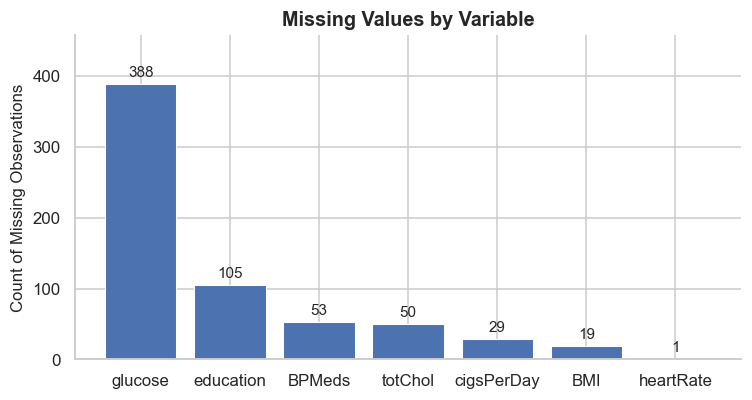

In [21]:
fig, ax = plt.subplots(figsize=(7, 3.8))

bars = ax.bar(missing_df.index, missing_df['Missing (n)'], color='#4C72B0', edgecolor='white', linewidth=0.7)
ax.bar_label(bars, padding=3, fontsize=10)

ax.set_title('Missing Values by Variable', fontweight='bold')
ax.set_ylabel('Count of Missing Observations')
ax.set_xlabel('')
ax.set_ylim(0, missing_df['Missing (n)'].max() * 1.18)
sns.despine()
plt.tight_layout()
plt.show()

**Takeaway:** Glucose has by far the most missing data at 9.2% (n = 388). That's significant enough that I need to think carefully about how to handle it: impute,, drop those rows, or note it as a limitation. The rest are pretty minor; education at 2.5% and BPMeds at 1.3% are manageable.

One thing worth asking is *why* glucose is missing so often. Is it random, or were certain types of patients less likely to have it recorded? That's hard to know without more context, but it's worth flagging before drawing conclusions from this variable.

## 4. Continuous Variables

I'm defining the continuous variables as the ones that represent measured quantities: `age`, `cigsPerDay`, `totChol`, `BMI`, `heartRate`, and `glucose`. For each one I want to look at the shape of the distribution and key summary stats.

In [22]:
cont_vars = ['age', 'cigsPerDay', 'totChol', 'BMI', 'heartRate', 'glucose']

stats_table = df[cont_vars].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'skew']).T
stats_table.columns = ['N (valid)', 'Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Skewness']
stats_table['N (valid)'] = stats_table['N (valid)'].astype(int)
stats_table['Missing'] = len(df) - stats_table['N (valid)']

# reorder columns
stats_table = stats_table[['N (valid)', 'Missing', 'Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Skewness']]
stats_table.round(2)

,N (valid),Missing,Mean,Median,Std Dev,Min,Max,Skewness
age,4240,0,49.58,49.00,8.57,32.00,70.00,0.23
cigsPerDay,4211,29,9.01,0.00,11.92,0.00,70.00,1.25
totChol,4190,50,236.70,234.00,44.59,107.00,696.00,0.87
BMI,4221,19,25.80,25.40,4.08,15.54,56.80,0.98
heartRate,4239,1,75.88,75.00,12.03,44.00,143.00,0.64
glucose,3852,388,81.96,78.00,23.95,40.00,394.00,6.21


A skewness of ~0 means symmetric. Between 0.5–1.0 is moderately skewed, above 1.0 is notably skewed. Glucose at 6.2 is extreme. That's basically saying there are a few wildly high values pulling the mean far above the median.

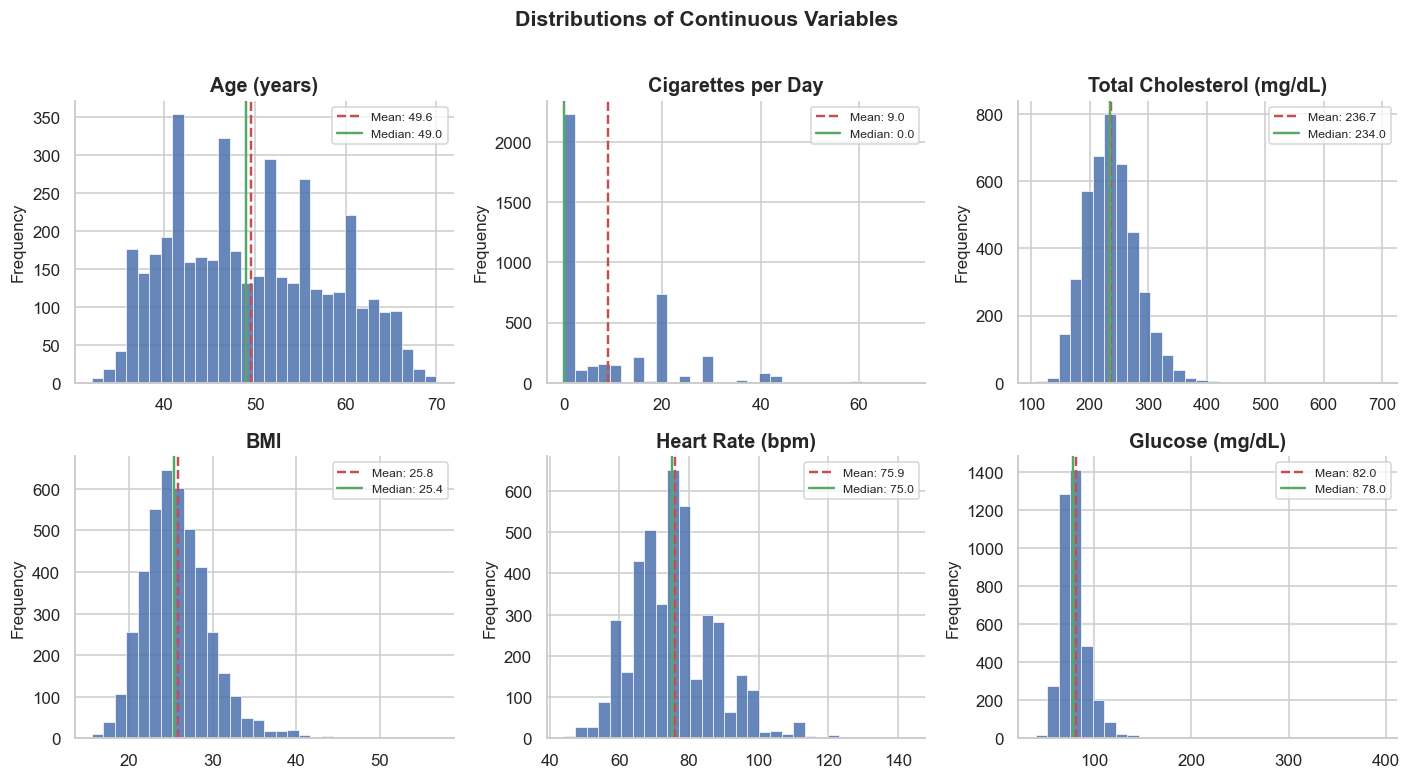

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(13, 7))
axes = axes.flatten()

labels = {
    'age': 'Age (years)',
    'cigsPerDay': 'Cigarettes per Day',
    'totChol': 'Total Cholesterol (mg/dL)',
    'BMI': 'BMI',
    'heartRate': 'Heart Rate (bpm)',
    'glucose': 'Glucose (mg/dL)'
}

for ax, var in zip(axes, cont_vars):
    data = df[var].dropna()
    ax.hist(data, bins=30, color='#4C72B0', edgecolor='white', linewidth=0.5, alpha=0.85)
    
    # mean and median lines
    ax.axvline(data.mean(), color='#C44E52', linewidth=1.6, linestyle='--', label=f'Mean: {data.mean():.1f}')
    ax.axvline(data.median(), color='#55A868', linewidth=1.6, linestyle='-', label=f'Median: {data.median():.1f}')
    
    ax.set_title(labels[var], fontweight='bold')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)
    sns.despine(ax=ax)

plt.suptitle('Distributions of Continuous Variables', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

**What I'm seeing:**

- **Age** is fairly symmetric, centered around 49–50. Nothing unusual.
- **Cigarettes per day** is heavily zero-inflated. The mode is zero because non-smokers are in there. The mean (9.0) is dragged up by heavy smokers. This variable probably shouldn't be treated as a typical continuous variable; it might be better split into smoker/non-smoker + a conditional count.
- **Total cholesterol** is roughly normal with a mild right tail. A few values up near 700 mg/dL are extreme and worth double-checking.
- **BMI** has a similar shape, mostly normal, right-skewed tail from a handful of very high values.
- **Heart rate** looks fairly normal. No major concerns.
- **Glucose** is the one that stands out. Almost all values cluster low, but there are extreme outliers above 300 mg/dL. The skewness of 6.2 reflects that. Log transformation would likely be needed before using this in a model.

### 4.1 Boxplots: Spotting Outliers

Histograms show shape well but boxplots are better for seeing outliers explicitly. I'll plot them side by side for the variables where I noticed skew or extreme values.

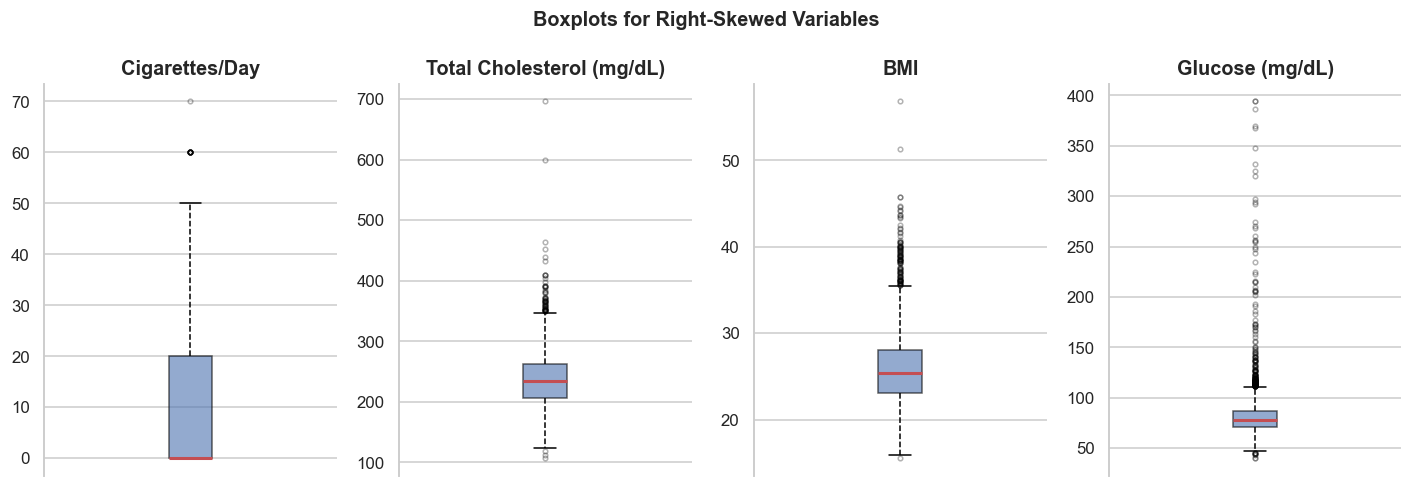

In [24]:
skewed_vars = ['cigsPerDay', 'totChol', 'BMI', 'glucose']
skewed_labels = ['Cigarettes/Day', 'Total Cholesterol (mg/dL)', 'BMI', 'Glucose (mg/dL)']

fig, axes = plt.subplots(1, 4, figsize=(13, 4.5))

for ax, var, label in zip(axes, skewed_vars, skewed_labels):
    data = df[var].dropna()
    ax.boxplot(data, vert=True, patch_artist=True,
               boxprops=dict(facecolor='#4C72B0', alpha=0.6),
               medianprops=dict(color='#C44E52', linewidth=2),
               whiskerprops=dict(linestyle='--'),
               flierprops=dict(marker='o', markersize=3, alpha=0.3, color='gray'))
    ax.set_title(label, fontweight='bold')
    ax.set_xticks([])
    sns.despine(ax=ax, bottom=True)

plt.suptitle('Boxplots for Right-Skewed Variables', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

Glucose is the clearest outlier situation. The interquartile range is tight but there's a long string of high-value fliers. For cholesterol and BMI, there are some high values but they're not as extreme relative to the rest of the distribution. Cigarettes per day has a lot of dots at zero, confirming the zero-inflation.

## 5. Categorical Variables

The categorical variables are `gender`, `currentSmoker`, `education`, `BPMeds`, `prevalentStroke`, `prevalentHyp`, `diabetes`, and `TenYearCHD` (the outcome). For these I want frequency counts and bar charts; summary statistics like mean don't really make sense for binary or nominal variables.

In [25]:
# Variable definitions from codebook
cat_vars = {
    'gender':          {0: 'Female', 1: 'Male'},
    'currentSmoker':   {0: 'Non-smoker', 1: 'Smoker'},
    'BPMeds':          {0: 'No', 1: 'Yes'},
    'prevalentStroke': {0: 'No', 1: 'Yes'},
    'prevalentHyp':    {0: 'No', 1: 'Yes'},
    'diabetes':        {0: 'No', 1: 'Yes'},
    'TenYearCHD':      {0: 'No CHD', 1: 'CHD'},
}
edu_map = {1.0: 'Elementary', 2.0: 'High School', 3.0: 'College', 4.0: 'Grad School'}

print('=== Categorical Variable Frequencies ===')
for var, mapping in cat_vars.items():
    counts = df[var].value_counts(dropna=False).rename(index={**{k: v for k, v in mapping.items()}, np.nan: 'Missing'})
    pct = (counts / counts.sum() * 100).round(1)
    out = pd.DataFrame({'Count': counts, '%': pct})
    print(f'\n--- {var} ---')
    print(out)

print('\n--- education ---')
edu_counts = df['education'].value_counts(dropna=False).rename(index={**edu_map, np.nan: 'Missing'})
edu_pct = (edu_counts / edu_counts.sum() * 100).round(1)
print(pd.DataFrame({'Count': edu_counts, '%': edu_pct}))

=== Categorical Variable Frequencies ===

--- gender ---
        Count     %
gender             
Female   2420 57.10
Male     1820 42.90

--- currentSmoker ---
               Count     %
currentSmoker             
Non-smoker      2145 50.60
Smoker          2095 49.40

--- BPMeds ---
        Count     %
BPMeds             
No       4063 95.80
Yes       124  2.90
NaN        53  1.20

--- prevalentStroke ---
                 Count     %
prevalentStroke             
No                4215 99.40
Yes                 25  0.60

--- prevalentHyp ---
              Count     %
prevalentHyp             
No             2923 68.90
Yes            1317 31.10

--- diabetes ---
          Count     %
diabetes             
No         4131 97.40
Yes         109  2.60

--- TenYearCHD ---
            Count     %
TenYearCHD             
No CHD       3596 84.80
CHD           644 15.20

--- education ---
             Count     %
education               
Elementary    1720 40.60
High School   1253 29.60
College 

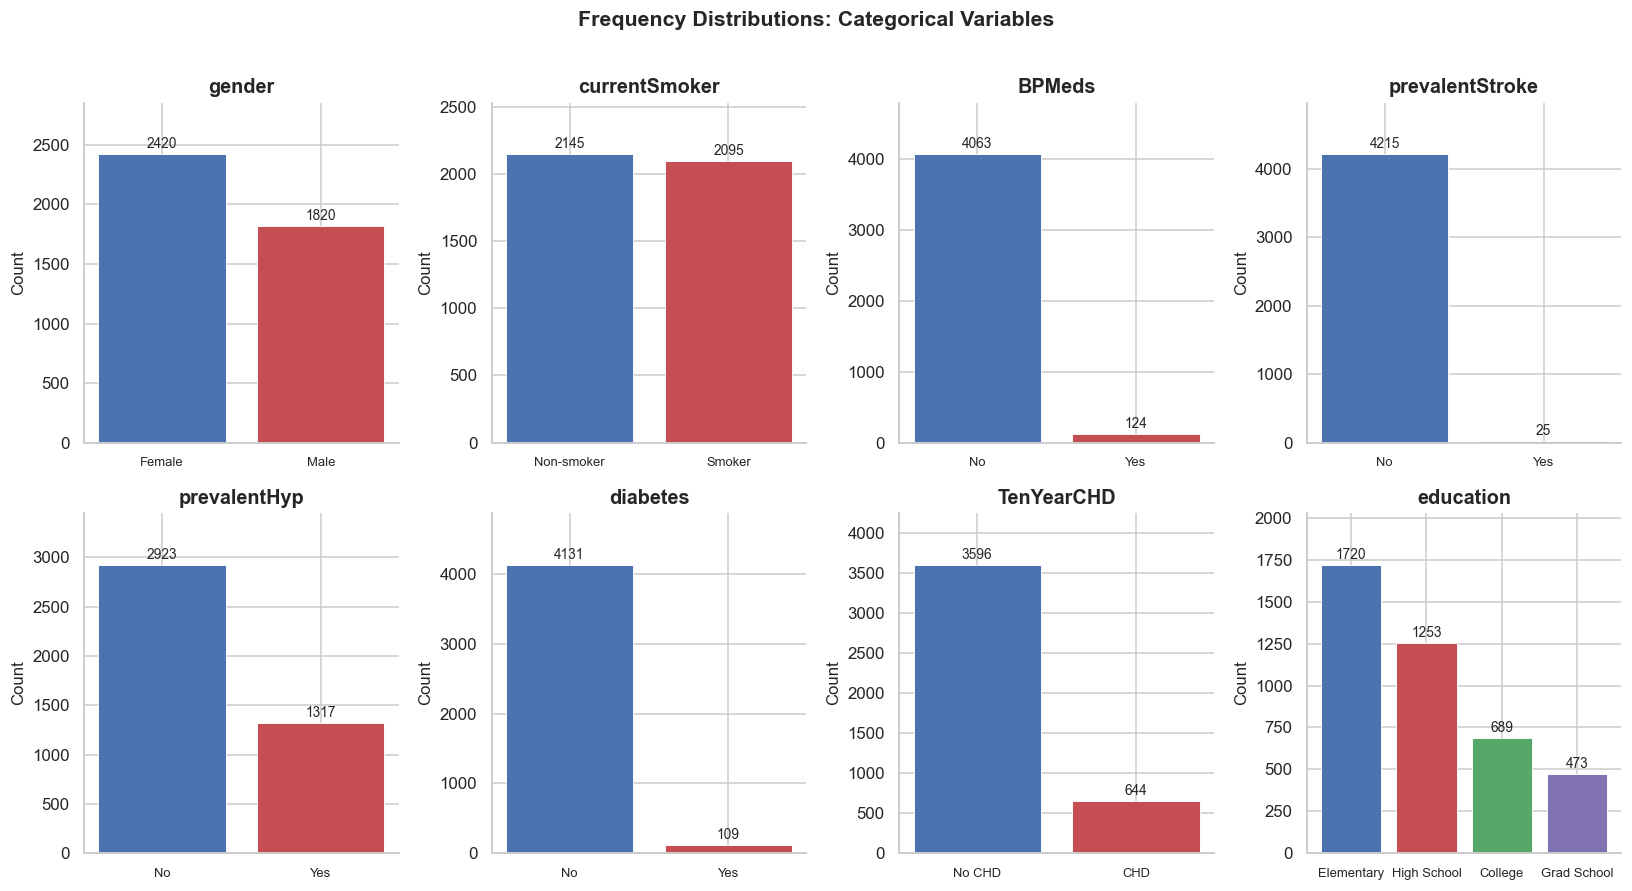

In [26]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

colors = ['#4C72B0', '#C44E52', '#55A868', '#8172B2']

all_cat = list(cat_vars.keys()) + ['education']

for ax, var in zip(axes, all_cat):
    if var == 'education':
        counts = df[var].value_counts(dropna=True).sort_index()
        xlabels = [edu_map[k] for k in counts.index]
    else:
        mapping = cat_vars[var]
        counts = df[var].value_counts(dropna=True).sort_index()
        xlabels = [mapping.get(k, str(k)) for k in counts.index]

    bar_colors = colors[:len(counts)]
    bars = ax.bar(xlabels, counts.values, color=bar_colors, edgecolor='white', linewidth=0.6)
    ax.bar_label(bars, padding=2, fontsize=9)
    ax.set_title(var, fontweight='bold')
    ax.set_ylabel('Count')
    ax.set_ylim(0, counts.max() * 1.18)
    ax.tick_params(axis='x', labelsize=8.5)
    sns.despine(ax=ax)

plt.suptitle('Frequency Distributions: Categorical Variables', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

**What stands out:**

- **Gender:** Mostly female (57%), which I'd want to keep in mind for any sex-stratified analysis.
- **Current smoker:** Nearly 50/50 split, which is actually a lot of smokers, consistent with this being a 1948 cohort when smoking rates were very high.
- **BPMeds, prevalent stroke, diabetes:** All heavily skewed toward 'No'; prevalentStroke is less than 1% Yes. These variables have very low variance, which can limit their statistical usefulness.
- **Prevalent hypertension:** 31% Yes, which is more reasonable.
- **Education:** Most participants only went through elementary school (40.6%). Reflects the era and the population.
- **TenYearCHD (outcome):** 15.2% developed CHD. This class imbalance matters a lot for modeling. A naive model that predicts 'No' every time would still get 85% accuracy, which would be misleading.

## 6. Outcome Variable Deep Dive: TenYearCHD

Since TenYearCHD is what we're ultimately trying to predict or understand, I want to look at how the continuous variables break down by CHD status. This starts to give a sense of which variables might be useful predictors.

In [27]:
# Mean of each continuous variable grouped by CHD outcome
outcome_summary = df.groupby('TenYearCHD')[cont_vars].mean().T
outcome_summary.columns = ['No CHD (0)', 'CHD (1)']
outcome_summary['Difference'] = outcome_summary['CHD (1)'] - outcome_summary['No CHD (0)']
outcome_summary.round(2)

,No CHD (0),CHD (1),Difference
age,48.76,54.15,5.38
cigsPerDay,8.71,10.63,1.92
totChol,235.15,245.39,10.24
BMI,25.67,26.53,0.86
heartRate,75.76,76.53,0.77
glucose,80.68,89.01,8.33


/var/folders/rn/d1hs0_vd44gfypj2t9vqbm5w0000gn/T/ipykernel_84959/3670649912.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bps = ax.boxplot(groups, labels=['No CHD', 'CHD'], patch_artist=True,
/var/folders/rn/d1hs0_vd44gfypj2t9vqbm5w0000gn/T/ipykernel_84959/3670649912.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bps = ax.boxplot(groups, labels=['No CHD', 'CHD'], patch_artist=True,
/var/folders/rn/d1hs0_vd44gfypj2t9vqbm5w0000gn/T/ipykernel_84959/3670649912.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bps = ax.boxplot(groups, labels=['No CHD', 'CHD'], patch_artist=True,
/var/folders/rn/d1hs0_vd44gf

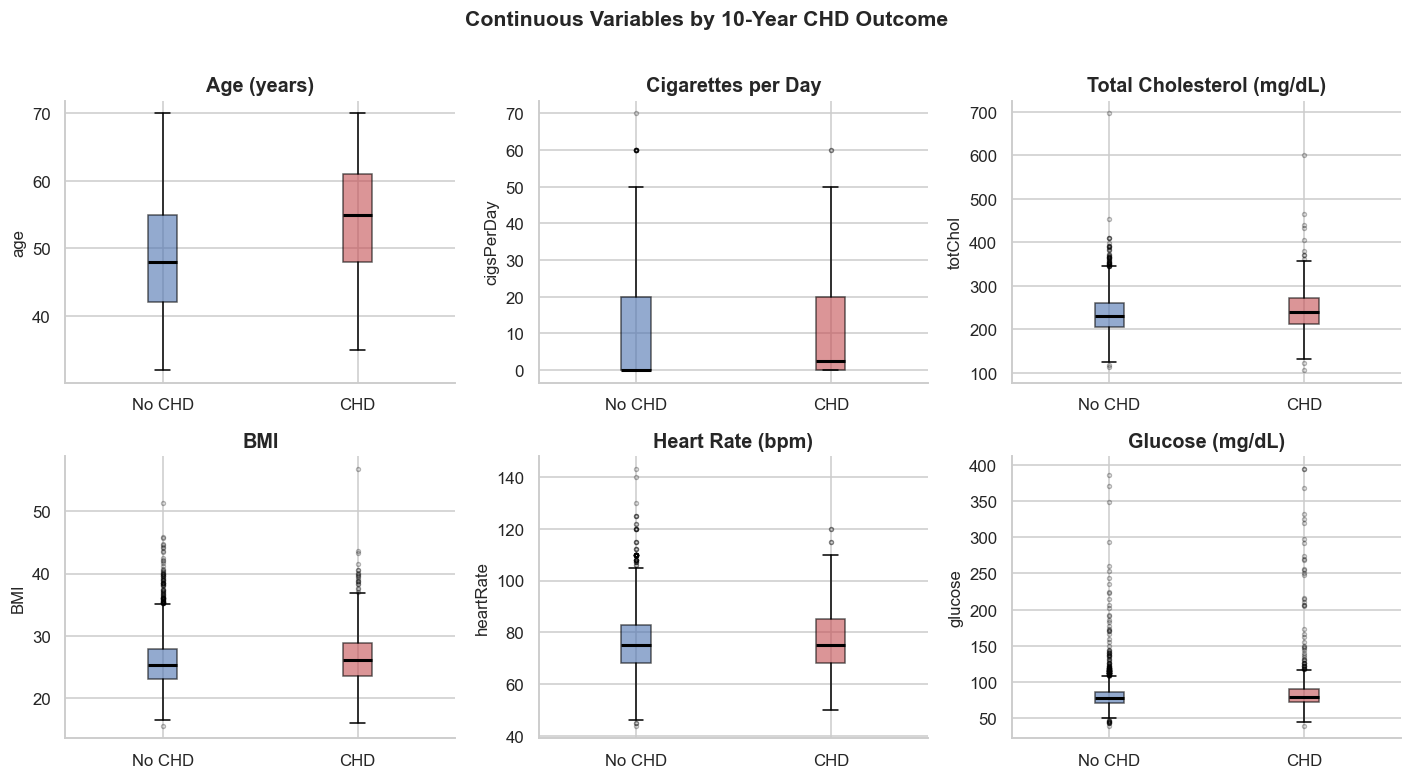

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(13, 7))
axes = axes.flatten()

palette = {0: '#4C72B0', 1: '#C44E52'}

for ax, var in zip(axes, cont_vars):
    data_plot = df[['TenYearCHD', var]].dropna()
    data_plot['CHD Status'] = data_plot['TenYearCHD'].map({0: 'No CHD', 1: 'CHD'})
    
    groups = [data_plot[data_plot['TenYearCHD'] == g][var].values for g in [0, 1]]
    bps = ax.boxplot(groups, labels=['No CHD', 'CHD'], patch_artist=True,
                     medianprops=dict(color='black', linewidth=2),
                     flierprops=dict(marker='o', markersize=2.5, alpha=0.3))
    
    for patch, color in zip(bps['boxes'], ['#4C72B0', '#C44E52']):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_title(labels[var], fontweight='bold')
    ax.set_ylabel(var)
    sns.despine(ax=ax)

plt.suptitle('Continuous Variables by 10-Year CHD Outcome', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

Age shows the clearest separation; people who developed CHD were, on average, several years older. Glucose also shows some separation, as does cholesterol to a lesser extent. Heart rate barely differs between groups, suggesting it might be a weaker predictor. These early observations which lines up with what the literature says about CHD risk factors.

## 7. Correlation: Continuous Variables vs. Outcome

A quick look at how each continuous variable correlates with TenYearCHD. Since the outcome is binary, these are point-biserial correlations (which Pearson handles fine for binary outcomes as a first pass).

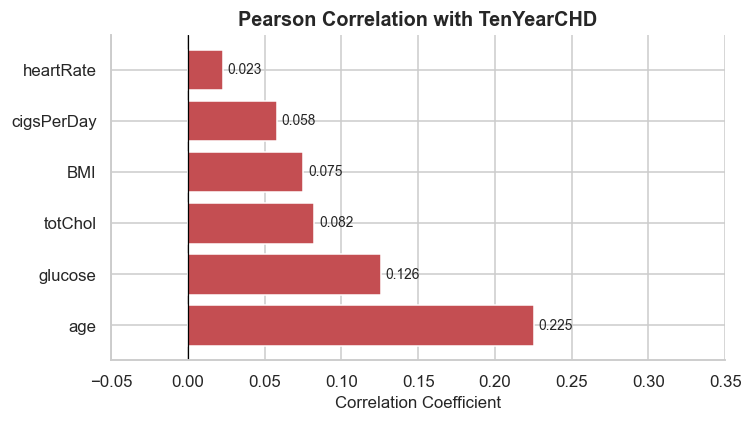

In [29]:
corr_with_outcome = df[cont_vars + ['TenYearCHD']].corr()['TenYearCHD'].drop('TenYearCHD').sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(7, 4))
bar_colors = ['#C44E52' if v > 0 else '#4C72B0' for v in corr_with_outcome]
bars = ax.barh(corr_with_outcome.index, corr_with_outcome.values, color=bar_colors, edgecolor='white')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('Pearson Correlation with TenYearCHD', fontweight='bold')
ax.set_xlabel('Correlation Coefficient')
ax.bar_label(bars, fmt='%.3f', padding=3, fontsize=9)
ax.set_xlim(-0.05, 0.35)
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

Age has the strongest correlation with the outcome (r = 0.225), which makes sense given that CHD risk increases with age. Glucose (0.126) and cholesterol (0.082) also have positive correlations with CHD, both in the expected direction. These correlations are modest in magnitude, which is pretty normal for complex disease outcomes. No single variable tells the whole story.

### 7.1 Correlation Heatmap: Among Continuous Variables

It's also worth checking whether any of the continuous predictors are highly correlated with each other, which could cause multicollinearity issues in regression.

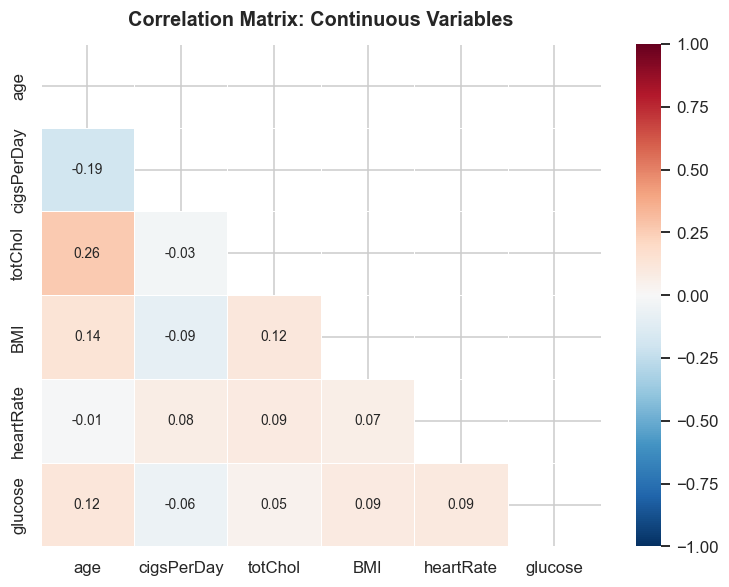

In [30]:
corr_matrix = df[cont_vars].corr()

fig, ax = plt.subplots(figsize=(7, 5.5))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # only show lower triangle

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, linewidths=0.5, ax=ax,
            annot_kws={'size': 9})

ax.set_title('Correlation Matrix: Continuous Variables', fontweight='bold', pad=12)
plt.tight_layout()
plt.show()

No severe multicollinearity here; the highest correlations are moderate at best. Age and BMI have a small positive correlation, as do glucose and BMI, which makes physiological sense. Nothing that would be immediately alarming for a regression model.

## 8. Summary of Key Findings

Here's what I'd flag going into any modeling or further analysis:

**Missing data:**
- `glucose` is missing for 9.2% of the sample, the largest gap. Whether the missingness is random or tied to something meaningful about those patients is unclear, so any analysis using glucose should note this as a limitation.
- `education`, `BPMeds`, and `totChol` have smaller but non-trivial missingness (1–2.5%).

**Distributional issues:**
- `glucose` is extremely right-skewed (skewness = 6.2). A log transformation would likely be needed before including it in a linear model.
- `cigsPerDay` is zero-inflated. Treating it as a simple continuous variable may not be appropriate; it might make more sense to split it into smoker/non-smoker plus a conditional count.
- `BMI` and `totChol` are moderately skewed but probably usable as-is.

**Low-variance categorical variables:**
- `prevalentStroke` (0.6% Yes) and `diabetes` (2.6% Yes) have very low prevalence. Estimates involving these will have wide confidence intervals and may not be reliable.

**Class imbalance in the outcome:**
- Only 15.2% of participants developed CHD. Any predictive model needs to account for this; accuracy alone would be a misleading metric here.

**Strongest predictors (preliminary):**
- Age has the clearest relationship with CHD outcome. Glucose, cholesterol, and prevalent hypertension also appear relevant. Heart rate shows very little separation between groups.